This file is to train a MLP to approximate MLP for eye-close-open data

Note that I have to retrain it because we have different freqs of the PSD

Note that you should convert the scale to dB with `20 log10(x)`  (on Jun 2, 2023)

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time
import multiprocessing as mp
from tqdm import tqdm

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
import models.mlp
importlib.reload(models.mlp)

<module 'models.mlp' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/mlp.py'>

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.mlp import SGMnet


In [6]:
# pkgs for pytorch 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.distributions.multivariate_normal import MultivariateNormal


torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)


## Data, fn and paras

In [7]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [8]:
# I have need the freqs
meg_root = DATA_ROOT/"MEG-eye-multiFreqs"
fil_paths = list(meg_root.glob("*.pkl"))
data = load_pkl(fil_paths[0]);
freqs = data.freqs

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../data/MEG-eye-multiFreqs/lcmv_DKregion_R2868E_02-st_1-45Hz_20_spectrogram.pkl


array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45.])

In [9]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

paras.saved_folder = RES_ROOT/"simu_sgm_data_ind_eye_close"
if not paras.saved_folder.exists():
    paras.saved_folder.mkdir()
    
paras.model_folder = RES_ROOT/"SGM_net_large_eye_close"
if not paras.model_folder.exists():
    paras.model_folder.mkdir()

sgmmodel = SGM(paras.C, paras.D, paras.freqs)

In [10]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 1000
paras_run.k = 0.15 # the parameter for reparameterization in logistic
paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

## Generate simulated data

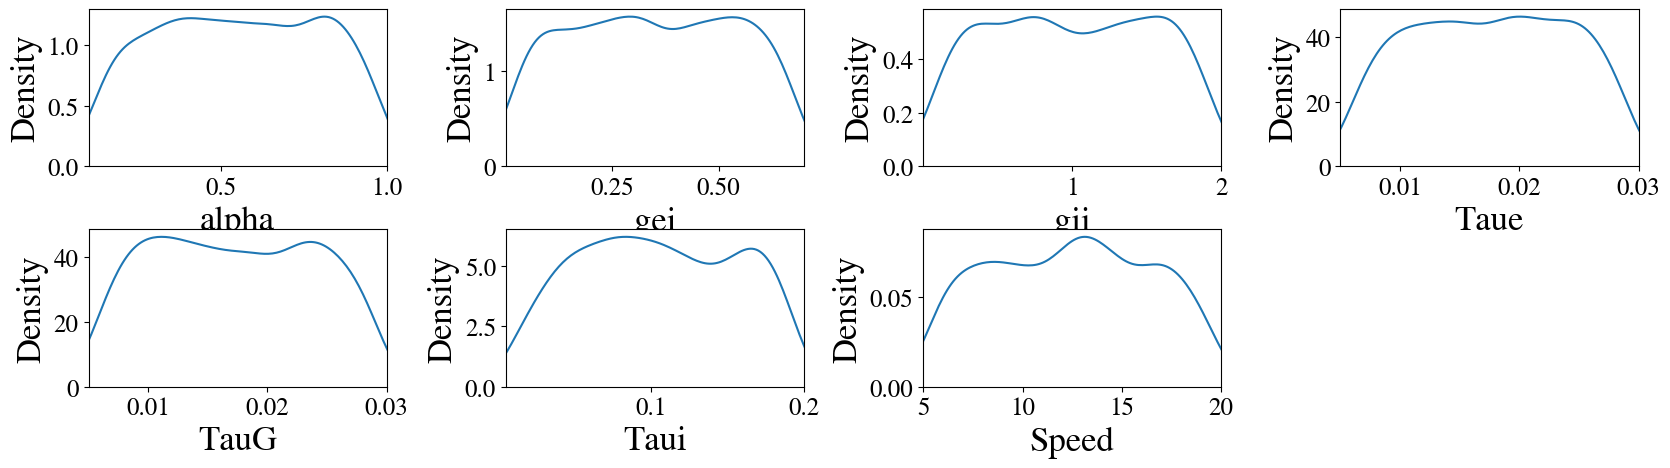

In [30]:
if not RUN_PYTHON_SCRIPT:
    #check the reparameterization
    sgm_params_raw = np.random.randn(1000, 7)*paras_run.sd
    sgm_paramss = raw2theta_np(sgm_params_raw, paras.prior_bds, k=paras_run.k)
    
    plt.figure(figsize=[20, 5])
    for ix in range(7):
        plt.subplot(2, 4, ix+1)
        sns.kdeplot(sgm_paramss[:, ix])
        plt.xlim(paras.prior_bds[ix, :])
        plt.xlabel(paras.names[ix])

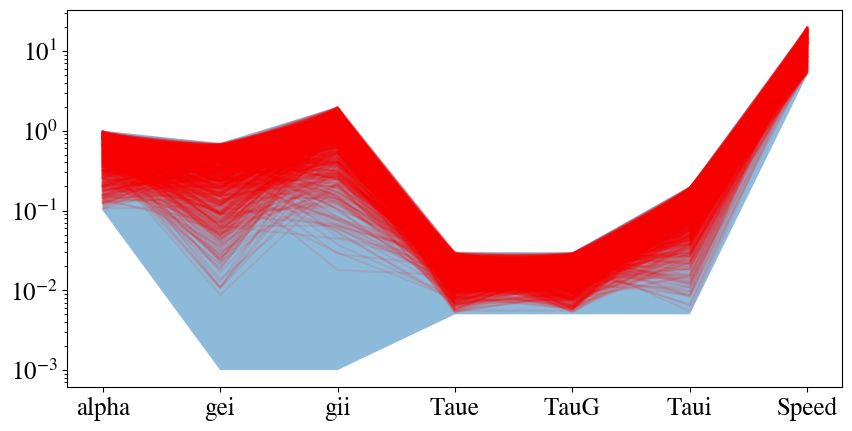

In [31]:
if not RUN_PYTHON_SCRIPT:
    #check the reparameterization
    plt.fill_between(np.arange(7), paras.par_low, paras.par_high, alpha=0.5)
    plt.yscale("log")
    for cur_ts_sgm in sgm_paramss:
        plt.plot(np.arange(7), cur_ts_sgm, color="red", alpha=0.1)
    plt.xticks(np.arange(7), paras.names);
    plt.show()
    plt.close()

In [32]:
# the function to generate PSD with SGM
def get_psd(cur_sgm):
    cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
    cur_PSD = cur_PSD[:68, :]
    return cur_PSD

In [15]:
# demo of PSD
if __name__ == "__main__":
    if not RUN_PYTHON_SCRIPT:
        sgm_params_raw = np.random.randn(100, 7)*paras_run.sd
        sgm_paramss = raw2theta_np(sgm_params_raw, paras.prior_bds, k=paras_run.k)
        
        num_cores = 20
        with mp.Pool(num_cores) as pool:
            PSDs = list(tqdm(pool.imap(get_psd, sgm_paramss), total=sgm_paramss.shape[0]))
        PSDs = np.array(PSDs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s]


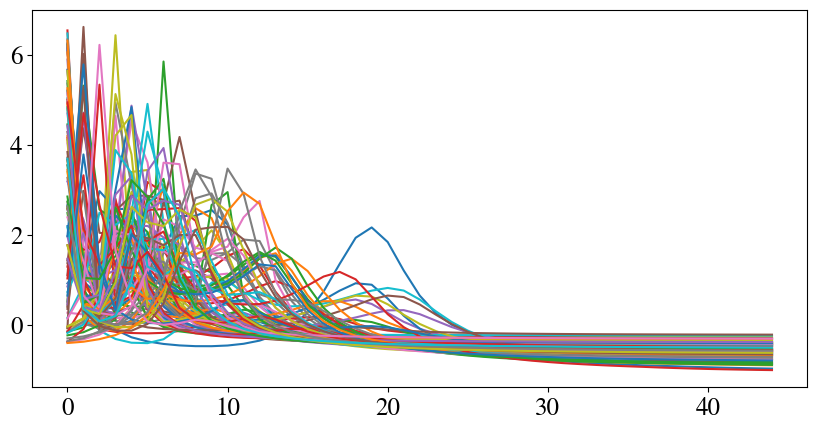

In [16]:
if not RUN_PYTHON_SCRIPT:
    for ix in range(100):
        dat = PSDs[ix]
        dat_std = (dat-dat.mean(axis=-1, keepdims=True))/dat.std(axis=-1, keepdims=True)
        seq = dat_std.mean(axis=0)
        plt.plot(dat_std.mean(axis=0))

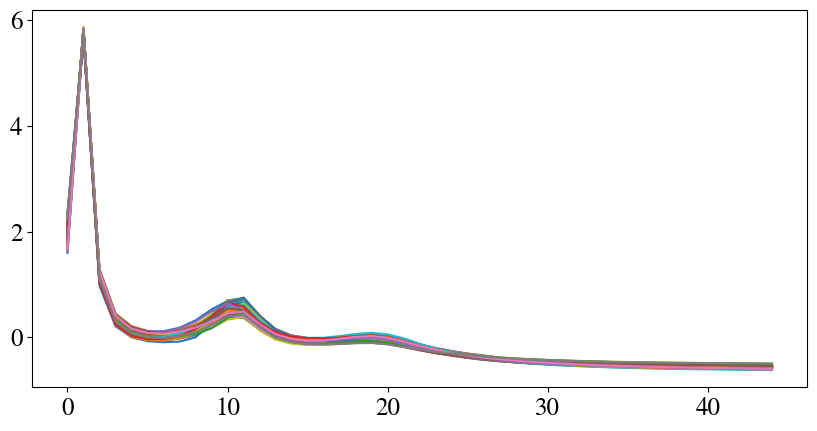

In [17]:
if not RUN_PYTHON_SCRIPT:
    ix = -20
    dat =PSDs[ix]
    dat_std = (dat-dat.mean(axis=-1, keepdims=True))/dat.std(axis=-1, keepdims=True)
    for ix in range(68):
        plt.plot(dat_std[ix])

In [33]:
if __name__ == "__main__":
    if not RUN_PYTHON_SCRIPT:
        print(f"save to {paras.saved_folder}") 
        sgm_params_raw = np.random.randn(100000, 7)*paras_run.sd
        sgm_paramss = raw2theta_np(sgm_params_raw, paras.prior_bds, k=paras_run.k)
        
        num_cores = 20
        with mp.Pool(num_cores) as pool:
            PSDs = list(tqdm(pool.imap(get_psd, sgm_paramss), total=sgm_paramss.shape[0]))
            
        simu_sgm_data = edict()
        simu_sgm_data.PSDs = np.array(PSDs)
        simu_sgm_data.sgm_paramss =  sgm_paramss
        simu_sgm_data.freqs = paras.freqs
        save_pkl_dict2folder(paras.saved_folder, simu_sgm_data, is_force=True)

save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [8:51:44<00:00,  3.13it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/PSDs.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/sgm_paramss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/freqs.pkl


In [ ]:
if __name__ == "__main__":
    if not RUN_PYTHON_SCRIPT:
        print(f"save to {paras.saved_folder}") 
        sgm_params_raw = np.random.randn(10000, 7)*paras_run.sd
        sgm_paramss = raw2theta_np(sgm_params_raw, paras.prior_bds, k=paras_run.k)
        
        num_cores = 20
        with mp.Pool(num_cores) as pool:
            PSDs = list(tqdm(pool.imap(get_psd, sgm_paramss), total=sgm_paramss.shape[0]))
            
        simu_sgm_data = edict()
        simu_sgm_data.PSDs_test = np.array(PSDs)
        simu_sgm_data.sgm_paramss_test =  sgm_paramss
        save_pkl_dict2folder(paras.saved_folder, simu_sgm_data, is_force=True)

save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close


 37%|█████████████████████████████████████████████████                                                                                    | 3688/10000 [19:18<27:00,  3.89it/s]

## Train the model

In [11]:
from torch.utils.data import DataLoader, Dataset
simu_sgm_data = load_pkl_folder2dict(paras.saved_folder);

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/PSDs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/PSDs_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/sgm_paramss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_ind_eye_close/sgm_paramss_test.pkl


In [12]:
class MyDataset(Dataset):
    def __init__(self, X, Y, is_std=True):
        """
        Initializes a new instance of the MyDataset class.

        Args:
            X (torch.Tensor or array-like): The input data.
            Y (torch.Tensor or array-like): The target data.
            is_std (bool, optional): Whether to standardize the target data. Defaults to True.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X)
        if not isinstance(Y, torch.Tensor):
            Y = torch.tensor(Y)
            
        # to dB scale
        Y = 20 * torch.log10(Y) # Y from SGM, is unsquared so, 20
        if is_std:
            # here I only divide by std of Y to keep the spatial features
            # In fact, it did not work for SGM to real MEG, so let me 
            # still std via the mean and std for each ROI and each data (Apr 3, 2023)
            Y = (Y-Y.mean(axis=2, keepdims=True))/Y.std(axis=2, keepdims=True)
        self.X = X
        self.Y = Y

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Gets the item at the specified index.

        Args:
            idx (int or str): The index of the item to get.

        Returns:
            tuple: A tuple containing the input data and target data.
        """
        if isinstance(idx, int):
            return self.X[idx], self.Y[idx]
        elif isinstance(idx, str) and idx.lower().startswith("all"):
            return self.X, self.Y


In [13]:
def weighted_mse_loss(pred, target, ws=None):
    """
    Calculates the weighted mean squared error loss between predicted and target values.

    Args:
        pred (torch.Tensor): predicted values
        target (torch.Tensor): target values
        ws (torch.Tensor, optional): weights for each value. Defaults to None.

    Returns:
        torch.Tensor: weighted mean squared error loss
    """
    if ws is None:
        ws = torch.ones_like(pred[0])
        hl_len = int(ws.shape[1]/2)
        ws[:, :hl_len] = ws[:, :hl_len]*10
    return torch.mean((pred-target)**2 * ws)

In [14]:
def evaluate(test_data_loader, net, loss_fn=None):
    if loss_fn is None:
        loss_fn = nn.MSELoss()
    net.eval()
    losses = []
    with torch.no_grad():
        for X_batch, Y_batch in test_data_loader:
            Y_batch_pred = net(X_batch)
            loss = loss_fn(Y_batch, Y_batch_pred)
            losses.append(loss.item())
    net.train()
    return np.mean(losses)

In [16]:
paras_sgm_net = edict()
paras_sgm_net.batchsize = 512
paras_sgm_net.nepoch = 1200
paras_sgm_net.loss_out = 20
paras_sgm_net.lr_step = 200

In [17]:
# the data loader for training and testing
train_data = MyDataset(simu_sgm_data.sgm_paramss, simu_sgm_data.PSDs)
train_data_loader = DataLoader(train_data, batch_size=paras_sgm_net.batchsize, shuffle=True)

test_data = MyDataset(simu_sgm_data.sgm_paramss_test, simu_sgm_data.PSDs_test)
test_data_loader = DataLoader(test_data, batch_size=paras_sgm_net.batchsize, shuffle=False)

In [18]:
# the network
sgm_net = SGMnet(nroi=68, nfreq=len(paras.freqs))
loss_fn = weighted_mse_loss
optimizer = torch.optim.Adam(sgm_net.parameters(), lr=1e-3, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.10, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
# training
loss_cur = []
losses = []
losses_test = []

t0 = time.time()
for ie in range(paras_sgm_net.nepoch):
    for X_batch, Y_batch in train_data_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        Y_batch_est = sgm_net(X_batch)
        #print(Y_batch_est.sum(axis=(1, 2)))
        
        loss = loss_fn(Y_batch, Y_batch_est)
        #print(loss)
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        loss_cur.append(loss.item())
        
    if ie % paras_sgm_net.lr_step == (paras_sgm_net.lr_step-1):
        scheduler.step()
    if ie % paras_sgm_net.loss_out == (paras_sgm_net.loss_out-1):
    
        losses.append(np.mean(loss_cur))
        losses_test.append(evaluate(test_data_loader, sgm_net))
        print(f"At epoch {ie+1}/{paras_sgm_net.nepoch},"
              f"the losses are {losses[-1]:.5f} (train)"
              f" and {losses_test[-1]:.5f} (test). "
              f"The time used is {delta_time(t0):.3f}s. "
              )
        loss_cur = []
        t0 = time.time()
    

At epoch 20/1200,the losses are 0.65122 (train) and 0.04047 (test). The time used is 253.520s. 
At epoch 40/1200,the losses are 0.32304 (train) and 0.03485 (test). The time used is 262.153s. 
At epoch 60/1200,the losses are 0.29430 (train) and 0.02787 (test). The time used is 278.970s. 
At epoch 80/1200,the losses are 0.23438 (train) and 0.00970 (test). The time used is 291.642s. 
At epoch 100/1200,the losses are 0.11092 (train) and 0.01050 (test). The time used is 285.007s. 
At epoch 120/1200,the losses are 0.09295 (train) and 0.00617 (test). The time used is 292.947s. 
At epoch 140/1200,the losses are 0.08509 (train) and 0.00478 (test). The time used is 286.723s. 
At epoch 160/1200,the losses are 0.07883 (train) and 0.00443 (test). The time used is 279.628s. 
At epoch 180/1200,the losses are 0.07381 (train) and 0.00449 (test). The time used is 275.445s. 
Adjusting learning rate of group 0 to 1.0000e-04.
At epoch 200/1200,the losses are 0.06987 (train) and 0.00800 (test). The time use

In [ ]:
if not RUN_PYTHON_SCRIPT:
    plt.plot(losses, label="Training loss")
    plt.plot(losses_test, label="Testing loss")
    plt.yscale("log")
    plt.legend()

In [ ]:
trained_model = edict()
trained_model.model = sgm_net.cpu()
trained_model.loss_fn = loss_fn
trained_model.optimizer = optimizer
trained_model.paras = paras_sgm_net
trained_model.loss = losses
trained_model.loss_test = losses_test
trained_model.freqs = paras.freqs
save_pkl_dict2folder(paras.model_folder, trained_model, is_force=True)

## Evaluate and save

In [23]:
if not RUN_PYTHON_SCRIPT:
    trained_model = load_pkl_folder2dict(paras.model_folder, excluding=["opt*"])

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/loss_fn.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large_eye_close/paras.pkl


In [24]:
sgm_net = trained_model.model
X_test, Y_test = train_data["all"]
sgm_net.eval()
with torch.no_grad():
    Y_pred = sgm_net(X_test)

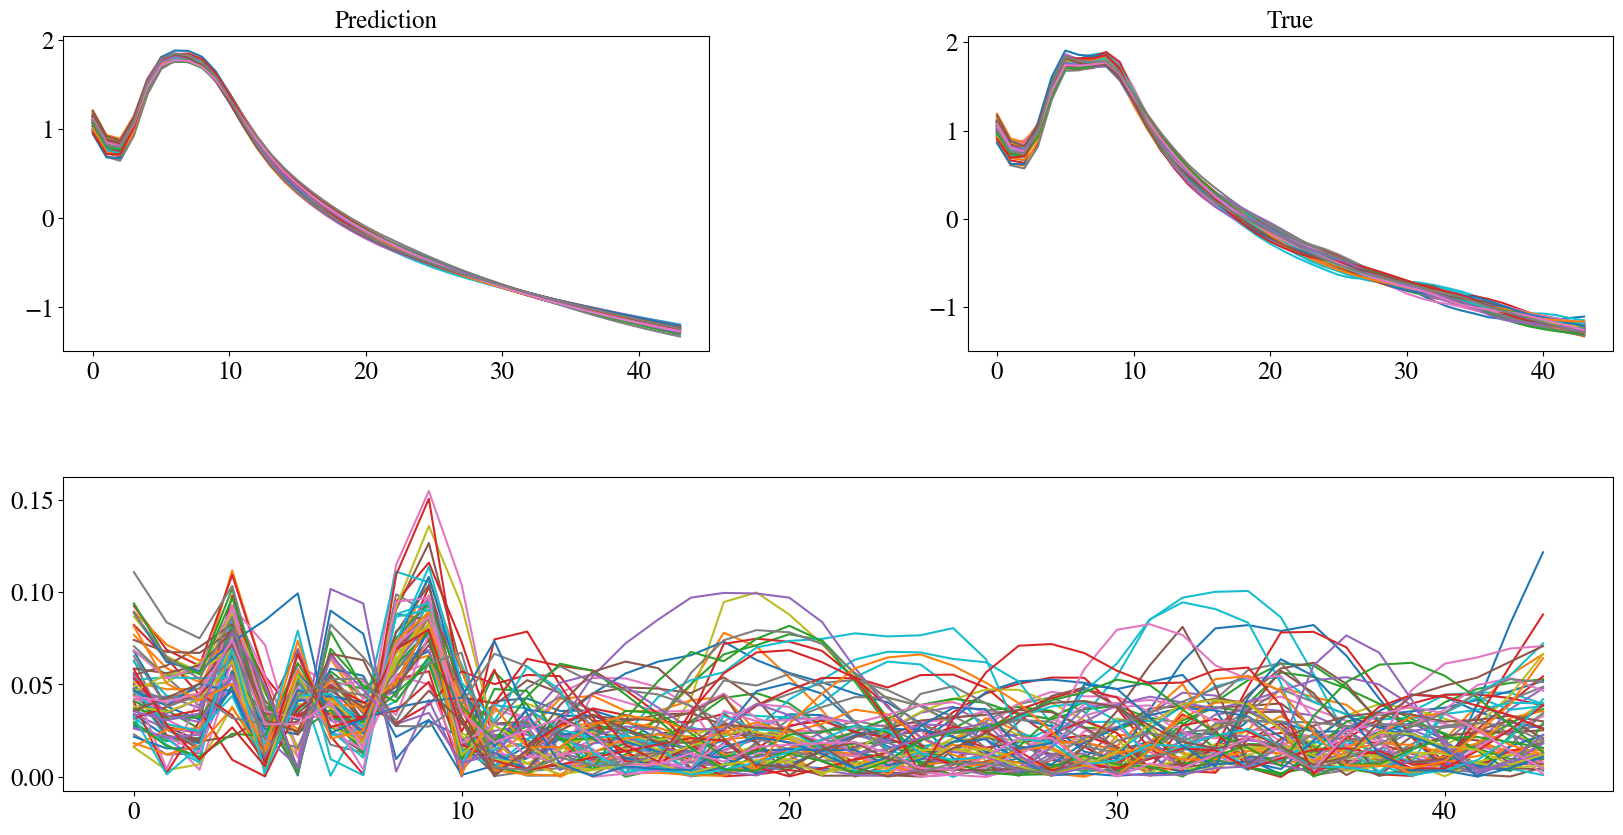

In [36]:
if not RUN_PYTHON_SCRIPT:
    idx = 2
    curY_t = Y_test[idx]
    curY_p = Y_pred[idx]
    plt.figure(figsize=[20, 10])
    plt.subplot(221)
    plt.title("Prediction")
    for iy in range(68):
        plt.plot(curY_p[iy, :])
    plt.subplot(222)
    plt.title("True")
    for iy in range(68):
        plt.plot(curY_t[iy, :])
        #plt.plot(torch.abs(curY_p[iy, :]- curY_t[iy, :]))
    plt.subplot(212)
    for iy in range(68):
        plt.plot(torch.abs(curY_p[iy, :]- curY_t[iy, :]))

In [28]:
if not RUN_PYTHON_SCRIPT:
    X_test, Y_test = test_data["all"]
    trained_model.model.eval()
    with torch.no_grad():
        Y_pred = trained_model.model(X_test)
    loss_fn = nn.MSELoss()
    print(loss_fn(Y_test, Y_pred))

tensor(0.0027)
